In [0]:
import pandas as pd

In [0]:
df_ge = pd.read_csv('ge.us.txt')

In [0]:
df_ge.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1962-01-02,0.6277,0.6362,0.6201,0.6201,2575579,0
1,1962-01-03,0.6201,0.6201,0.6122,0.6201,1764749,0
2,1962-01-04,0.6201,0.6201,0.6037,0.6122,2194010,0
3,1962-01-05,0.6122,0.6122,0.5798,0.5957,3255244,0
4,1962-01-08,0.5957,0.5957,0.5716,0.5957,3696430,0


In [0]:
df_ge.tail()

,Date,Open,High,Low,Close,Volume,OpenInt
14053,2017-11-06,20.52,20.530,20.08,20.13,60641787,0
14054,2017-11-07,20.17,20.250,20.12,20.21,41622851,0
14055,2017-11-08,20.21,20.320,20.07,20.12,39672190,0
14056,2017-11-09,20.04,20.071,19.85,19.99,50831779,0
14057,2017-11-10,19.98,20.680,19.90,20.49,100698474,0


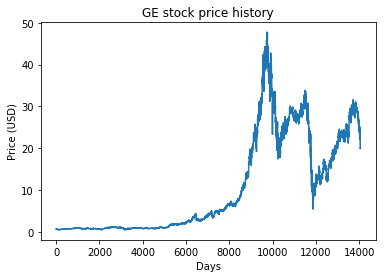

In [0]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(df_ge["Open"])
plt.title('GE stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.show()

In [0]:
import seaborn as sns

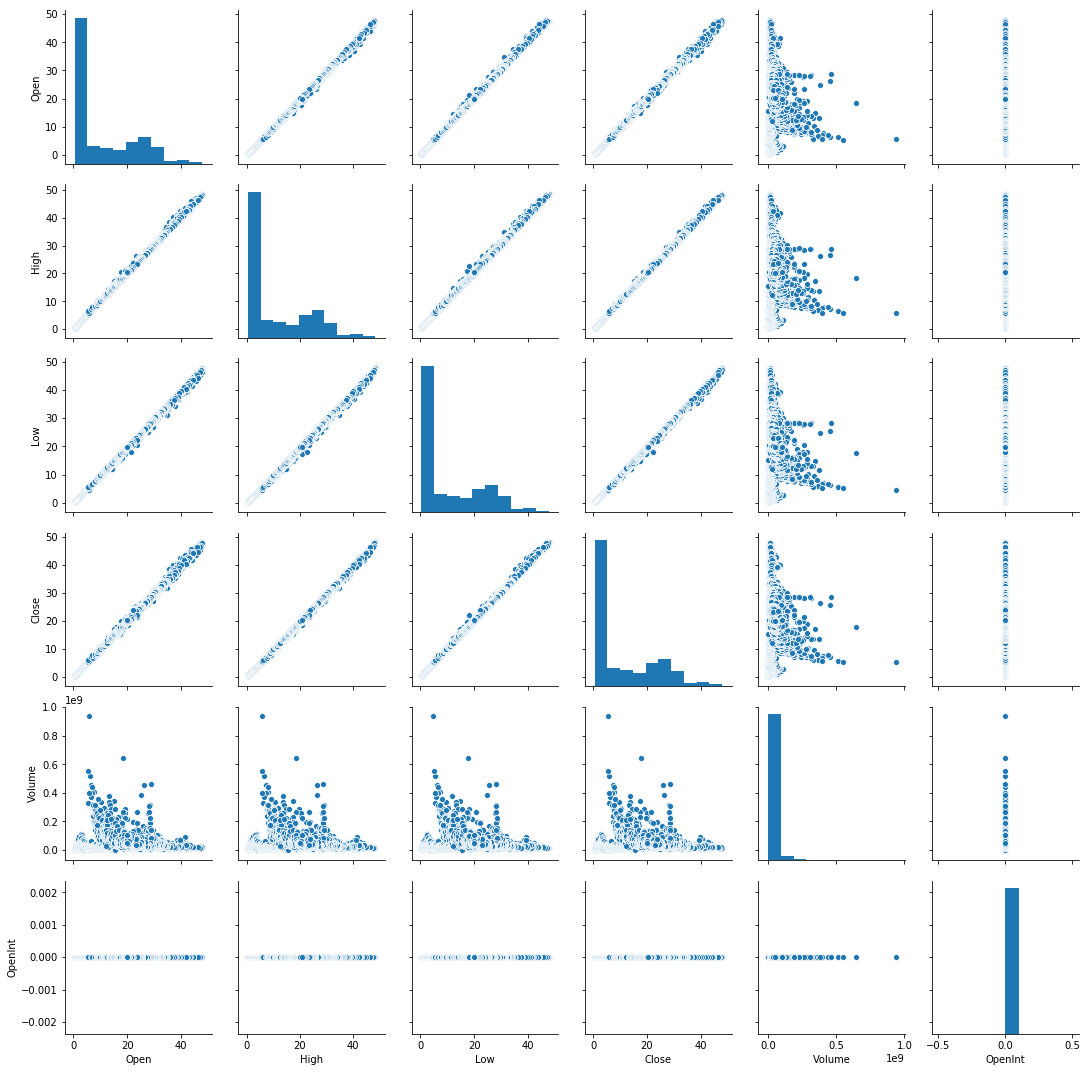

In [0]:
sns.pairplot(df_ge)

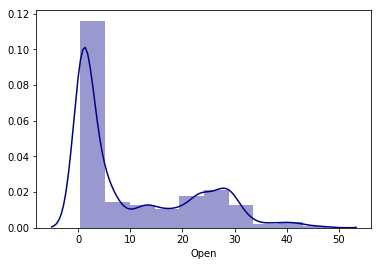

In [0]:
sns.distplot(df_ge["Open"].dropna() , kde = True , color = 'darkblue' , bins = 10) 

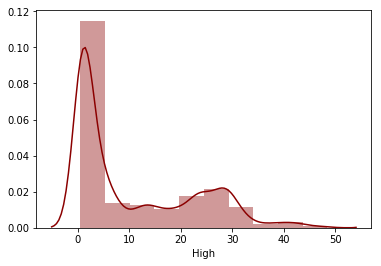

In [0]:
sns.distplot(df_ge["High"].dropna() , kde = True , color = 'darkred' , bins = 10) 

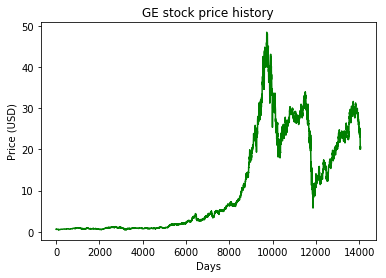

In [0]:
plt.figure()
plt.plot(df_ge["High"] , 'g')
plt.title('GE stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.show()

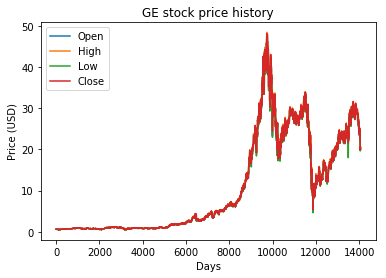

In [0]:
plt.figure()
plt.plot(df_ge["Open"])
plt.plot(df_ge["High"])
plt.plot(df_ge["Low"])
plt.plot(df_ge["Close"])
plt.title('GE stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

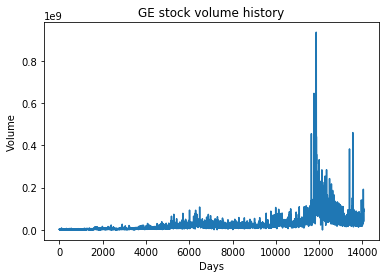

In [0]:
plt.figure()
plt.plot(df_ge["Volume"])
plt.title('GE stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

In [0]:
df_ge.isna().sum()

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64

In [0]:
df_ge.describe()

,Open,High,Low,Close,Volume,OpenInt
count,14058.000000,14058.000000,14058.000000,14058.000000,1.405800e+04,14058.0
mean,10.534737,10.642538,10.421090,10.534161,2.423066e+07,0.0
std,11.742897,11.868891,11.612159,11.743726,3.369859e+07,0.0
min,0.459020,0.466900,0.451140,0.459020,0.000000e+00,0.0
25%,0.901500,0.909600,0.893800,0.901500,5.496950e+06,0.0
50%,3.880900,3.912700,3.824300,3.884800,1.597520e+07,0.0
75%,21.416000,21.658000,21.149250,21.370000,2.853667e+07,0.0
max,47.751000,48.459000,47.596000,48.056000,9.345354e+08,0.0


In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

train_cols = ["Open" , "High" , "Low" , "Close" , "Volume"]
df_train, df_test = train_test_split(df_ge , train_size = 0.8 , test_size = 0.2, shuffle = False)
print("Train and Test size", len(df_train), len(df_test))
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

Train and Test size 11246 2812


In [0]:
import numpy as np

In [0]:
TIME_STEPS = 60
BATCH_SIZE = 100

In [0]:
from tqdm import tqdm_notebook as tqdm
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [0]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [0]:
x_t , y_t = build_timeseries(x_train , 3)
x_t = trim_dataset(x_t , BATCH_SIZE)
y_t = trim_dataset(y_t , BATCH_SIZE)
x_temp , y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)


length of time-series i/o (11186, 60, 5) (11186,)



length of time-series i/o (2752, 60, 5) (2752,)


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.layers import Dropout
from keras import optimizers
lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=0.001)
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

W0719 06:51:32.237414 139783400671104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'your_log_name' + '.log'), append=True)

history = model.fit(x_t, y_t, epochs=your_epochs, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)), callbacks=[csv_logger])

In [0]:
try:
    from hyperopt import Trials, STATUS_OK, tpe, fmin, hp
except:
    !pip install hyperopt
    from hyperopt import Trials, STATUS_OK, tpe
import numpy as np
import pandas as pd
import os
import sys
import time
import pandas as pd
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import pickle
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Embedding
from keras.layers import LSTM
import keras
from keras.callbacks import Callback
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import CSVLogger
from sklearn.model_selection import GridSearchCV
# import psutil
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

import logging
import itertools as it

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from keras import backend as K

print("checking if GPU available", K.tensorflow_backend._get_available_gpus())

print("current path", os.getcwd())
INPUT_PATH = os.path.join(PATH_TO_DRIVE_ML_DATA, "inputs")
OUTPUT_PATH = os.path.join(PATH_TO_DRIVE_ML_DATA, "outputs")
LOG_PATH = OUTPUT_PATH
LOG_FILE_NAME_PREFIX = "stock_pred_lstm_"
LOG_FILE_NAME_SUFFIX = ".log"

TIME_STEPS = 90  # 3 months
BATCH_SIZE = 20
stime = time.time()

def print_time(text, stime):
    seconds = (time.time() - stime)
    print(text + " " + str(seconds // 60) + " minutes : " + str(np.round(seconds % 60)) + " seconds")

def get_readable_ctime():
    return time.strftime("%d-%m-%Y %H_%M_%S")

def init_logging():
    logging.basicConfig(level=logging.INFO)
    log_formatter = logging.Formatter("%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s")
    root_logger = logging.getLogger()

    file_handler = logging.FileHandler(os.path.join(LOG_PATH, LOG_FILE_NAME_PREFIX + get_readable_ctime()+".log")) # "{0}/{1}.log".format(LOG_PATH, LOG_FILE_NAME_PREFIX + get_readable_ctime()))
    file_handler.setFormatter(log_formatter)
    root_logger.addHandler(file_handler)

    console_handler = logging.StreamHandler()
    console_handler.setFormatter(log_formatter)
    root_logger.addHandler(console_handler)

def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0] % batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat


def build_timeseries(mat, y_col_index, time_steps):
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - time_steps
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, time_steps, dim_1))
    y = np.zeros((x.shape[0],))

    for i in tqdm(range(dim_0)):
        x[i] = mat[i:time_steps + i]
        y[i] = mat[time_steps + i, y_col_index]
    print("length of time-series i/o {} {}".format(x.shape, y.shape))
    return x, y

stime = time.time()
init_logging()
print(str(os.listdir(INPUT_PATH)))  # ge.us.txt
df_ge = pd.read_csv(os.path.join(INPUT_PATH,"ge.us.txt"), engine='python')
print(str(df_ge.shape))
print(str(df_ge.columns))

train_cols = ["Open", "High", "Low", "Close", "Volume"]
df_train, df_test = train_test_split(df_ge, train_size=0.8, test_size=0.2, shuffle=False)
print("Train--Test size {} {}".format(len(df_train), len(df_test)))

# scale the feature MinMax, build array
mat = df_ge.loc[:, train_cols].values

print("Deleting unused dataframes of total size(KB) {}"
      .format((sys.getsizeof(df_ge) + sys.getsizeof(df_train) + sys.getsizeof(df_test)) // 1024))

del df_ge
del df_test
del df_train

csv_logger = CSVLogger(OUTPUT_PATH + 'log_' + get_readable_ctime() + '.log', append=True)

class LogMetrics(Callback):

    def __init__(self, search_params, param, comb_no):
        self.param = param
        self.self_params = search_params
        self.comb_no = comb_no
        
    def on_epoch_end(self, epoch, logs):
        for i, key in enumerate(self.self_params.keys()):
            logs[key] = self.param[key]
        logs["combination_number"] = self.comb_no


def data_dummy():
    return None, None, None, None


def data(batch_size, time_steps):
    global mat

    BATCH_SIZE = batch_size
    TIME_STEPS = time_steps
    x_train, x_test = train_test_split(mat, train_size=0.8, test_size=0.2, shuffle=False)

    # scale the train and test dataset
    min_max_scaler = MinMaxScaler()
    x_train = min_max_scaler.fit_transform(x_train)
    x_test = min_max_scaler.transform(x_test)

    x_train_ts, y_train_ts = build_timeseries(x_train, 3, TIME_STEPS)
    x_test_ts, y_test_ts = build_timeseries(x_test, 3, TIME_STEPS)
    x_train_ts = trim_dataset(x_train_ts, BATCH_SIZE)
    y_train_ts = trim_dataset(y_train_ts, BATCH_SIZE)
    x_test_ts = trim_dataset(x_test_ts, BATCH_SIZE)
    y_test_ts = trim_dataset(y_test_ts, BATCH_SIZE)
    print("Test size(trimmed) {}, {}".format(x_test_ts.shape, y_test_ts.shape))

    print("Are any NaNs present in train/test matrices?{0},{1}".format(str(np.isnan(x_train).any()),
                                                                       str(np.isnan(x_test).any())))
    return x_train_ts, y_train_ts, x_test_ts, y_test_ts


search_space = {
    'batch_size': hp.choice('bs', [30,40,50,60,70]),
    'time_steps': hp.choice('ts', [30,50,60,80,90]),
    'lstm1_nodes':hp.choice('units_lsmt1', [70,80,100,130]),
    'lstm1_dropouts':hp.uniform('dos_lstm1',0,1),
    'lstm_layers': hp.choice('num_layers_lstm',[
        {
            'layers':'one', 
        },
        {
            'layers':'two',
            'lstm2_nodes':hp.choice('units_lstm2', [20,30,40,50]),
            'lstm2_dropouts':hp.uniform('dos_lstm2',0,1)  
        }
        ]),
    'dense_layers': hp.choice('num_layers_dense',[
        {
            'layers':'one'
        },
        {
            'layers':'two',
            'dense2_nodes':hp.choice('units_dense', [10,20,30,40])
        }
        ]),
    "lr": hp.uniform('lr',0,1),
    "epochs": hp.choice('epochs', [30, 40, 50, 60, 70]),
    "optimizer": hp.choice('optmz',["sgd", "rms"])
}


def create_model_hypopt(params):
    print("Trying params:",params)
    batch_size = params["batch_size"]
    time_steps = params["time_steps"]
    x_train_ts, y_train_ts, x_test_ts, y_test_ts = data(batch_size, time_steps)
    lstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(params["lstm1_nodes"], batch_input_shape=(batch_size, time_steps, x_train_ts.shape[2]), dropout=params["lstm1_dropouts"],
                        recurrent_dropout=params["lstm1_dropouts"], stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))  
    # ,return_sequences=True #LSTM params => dropout=0.2, recurrent_dropout=0.2
    if params["lstm_layers"]["layers"] == "two":
        lstm_model.add(LSTM(params["lstm_layers"]["lstm2_nodes"], dropout=params["lstm_layers"]["lstm2_dropouts"]))
    else:
        lstm_model.add(Flatten())

    if params["dense_layers"]["layers"] == 'two':
        lstm_model.add(Dense(params["dense_layers"]["dense2_nodes"], activation='relu'))
    
    lstm_model.add(Dense(1, activation='sigmoid'))

    lr = params["lr"]
    epochs = params["epochs"]
    if params["optimizer"] == 'rms':
        optimizer = optimizers.RMSprop(lr=lr)
    else:
        optimizer = optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)

    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)  # binary_crossentropy
    history = lstm_model.fit(x_train_ts, y_train_ts, epochs=epochs, verbose=2, batch_size=batch_size,
                             validation_data=[x_test_ts, y_test_ts],
                             callbacks=[LogMetrics(search_space, params, -1), csv_logger])
    # for key in history.history.keys():
    #     print(key, "--",history.history[key])
    # get the highest validation accuracy of the training epochs
    val_error = np.amin(history.history['val_loss']) 
    print('Best validation error of epoch:', val_error)
    return {'loss': val_error, 'status': STATUS_OK, 'model': lstm_model} # if accuracy use '-' sign
    

trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=2000,
    trials=trials)

pickle.dump(best, open(os.path.join(OUTPUT_PATH,"hyperopt_res"),"wb"))

print(best)
print_time("program completed in", stime)

Using TensorFlow backend.


checking if GPU available []
current path /content


NameError: ignored